# Classifier Evaluation


This notebook assumes precomputed ground truth maps either as pickles or csv files. The ground truth is expected to include the following classes:
1. background
2. sand
3. construction sand
4. soil
5. fish food


In [23]:
from spectral import *
import netCDF4 as nc
import numpy as np
import matplotlib.pyplot as plt
import cv2 as cv
import pickle
from os.path import exists
from matplotlib import cm
import os
from sklearn.decomposition import PCA
# from sklearn.cluster import KMeans

In [32]:
def process_into_rgb(loc_ds):
    """
    Processes a given dataset into an rgb image for display
    """
    loc_dc = np.array(loc_ds['datacube'])
    loc_binned_wavelengths = np.array(loc_ds['wavelength'])
    loc_image = np.zeros((loc_dc.shape[1],loc_dc.shape[2],3), np.uint8)

    loc_red_wavelength = 620
    loc_green_wavelength = 560
    loc_blue_wavelength = 470

    loc_red_layer = loc_dc[np.argmin(np.abs(loc_binned_wavelengths-loc_red_wavelength)),:,:]  
    loc_green_layer = loc_dc[np.argmin(np.abs(loc_binned_wavelengths-loc_green_wavelength)),:,:] 
    loc_blue_layer = loc_dc[np.argmin(np.abs(loc_binned_wavelengths-loc_blue_wavelength)),:,:] 

    # loc_red_layer = loc_dc[120,:,:]  
    # loc_green_layer = loc_dc[80,:,:] 
    # loc_blue_layer = loc_dc[20,:,:] 

    loc_image[:,:,0] = loc_red_layer
    loc_image[:,:,1] = loc_green_layer
    loc_image[:,:,2] = loc_blue_layer

    # scale the values to within the central 2 to 98 percent values to remove outlier readings
    loc_vmax = np.nanpercentile(loc_image, 98)
    loc_vmin = np.nanpercentile(loc_image, 2)
    loc_image = ((loc_image.astype("f8") - loc_vmin) / (loc_vmax - loc_vmin)).astype("f4")
    loc_image = np.minimum(np.maximum(loc_image, 0), 1)

    loc_image *= 255
    loc_image = loc_image.astype(np.uint8)
    
    return loc_image

1. background
2. sand
3. construction sand
4. soil
5. fish food

In [35]:
# Setup required variables

class_strings = {}

class_strings[1] = "red"
class_strings[2] = "green"
class_strings[3] = "blue"
class_strings[4] = "yellow"
class_strings[5] = "purple"

classes = [1,2,3,4,5]

empty = [0,0,0,0,0]

data_path = "processed-data/secondary-capture/reflectance/2022_11_08"
rad_path = "processed-data/secondary-capture/2022_11_08"

classifications = []
ground_truths = []

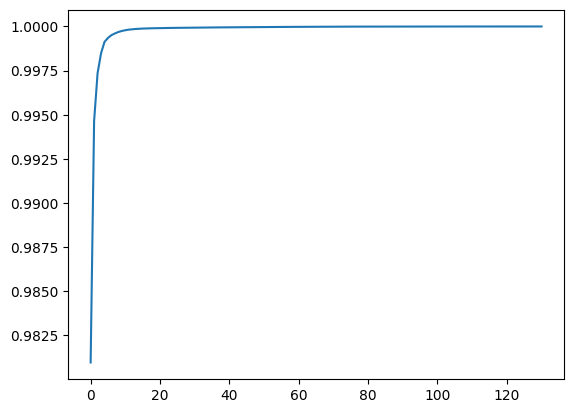

In [8]:
# Perform elbow method on random image to assess pca components
run = True
if run:
    pca = PCA()

    data = np.array(nc.Dataset("processed-data/secondary-capture/reflectance/2022_11_08/2022_11_08-02_27_29.nc")['datacube']).transpose(1,2,0)
    X = data.reshape(data.shape[0]*data.shape[1],data.shape[2])

    # fit my data, and transform
    pcX = pca.fit_transform(X)

    # graph the variance of each component (should give a good idea about the number of components to use).
    ev = pca.explained_variance_ratio_
    cumulativeVar = np.cumsum(ev)
    plt.plot(cumulativeVar)

In [9]:
# pick number of components that seems reasonable.
nComp = 5 # covers more than 95% of variance

/home/solomon/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/solomon/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/solomon/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/solomon/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/solomon/.local/lib/pyt

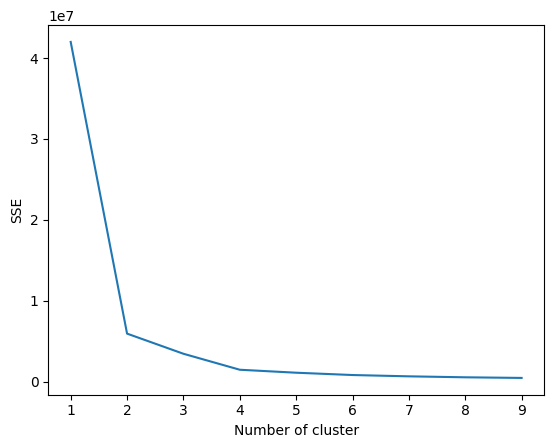

In [16]:
# K-means elbow method to determine optimal n_clusters
run = True
if run:
    sse = {}
    for k in range(1, 10):
        kmeans = KMeans(n_clusters=k).fit(pcX)
        # data["clusters"] = kmeans.labels_
        # print(data["clusters"])
        sse[k] = kmeans.inertia_ # Inertia: Sum of distances of samples to their closest cluster center
    plt.figure()
    plt.plot(list(sse.keys()), list(sse.values()))
    plt.xlabel("Number of cluster")
    plt.ylabel("SSE")
    plt.show()

In [38]:
# pick number of components that seems reasonable.
nClusters = 5 # covers the known number of classes in the image

['2022_11_08-02_55_33.csv', '2022_11_08-03_07_05.nc', '2022_11_08-03_05_38.nc', '2022_11_08-02_59_16.png', '2022_11_08-02_57_06.png', '2022_11_08-02_34_13.csv', '2022_11_08-02_35_55.nc', '2022_11_08-02_29_59.nc', '2022_11_08-02_27_29.nc', '2022_11_08-02_36_42.png', '2022_11_08-02_54_09.png', '2022_11_08-02_56_33.nc', '2022_11_08-03_05_38.png', '2022_11_08-02_34_13.nc', '2022_11_08-02_29_19.png', '2022_11_08-02_35_55.png', '2022_11_08-02_49_58.csv', '2022_11_08-02_27_29.png', '2022_11_08-03_00_10.csv', '2022_11_08-02_57_06.nc', '2022_11_08-03_06_08.csv', '2022_11_08-02_49_58.png', '2022_11_08-03_07_05.png', '2022_11_08-02_55_33.nc', '2022_11_08-02_35_55.csv', '2022_11_08-02_36_42.nc', '2022_11_08-03_02_28.nc', '2022_11_08-02_36_42.csv', '2022_11_08-02_54_47.nc', '2022_11_08-02_29_19.csv', '2022_11_08-02_54_47.png', '2022_11_08-03_01_21.nc', '2022_11_08-02_28_28.png', '2022_11_08-03_04_29.csv', '2022_11_08-02_59_16.csv', '2022_11_08-02_49_26.csv', '2022_11_08-02_29_19.nc', '2022_11_08-03

spectral:INFO: k-means iteration 1 - 160403 pixels reassigned.
spectral:INFO: k-means iteration 2 - 43549 pixels reassigned.
spectral:INFO: k-means iteration 3 - 13919 pixels reassigned.
spectral:INFO: k-means iteration 4 - 11618 pixels reassigned.
spectral:INFO: k-means iteration 5 - 7091 pixels reassigned.
spectral:INFO: k-means iteration 6 - 4713 pixels reassigned.
spectral:INFO: k-means iteration 7 - 3028 pixels reassigned.
spectral:INFO: k-means iteration 8 - 1845 pixels reassigned.
spectral:INFO: k-means iteration 9 - 1460 pixels reassigned.
spectral:INFO: k-means iteration 10 - 1170 pixels reassigned.
spectral:INFO: k-means iteration 11 - 1084 pixels reassigned.
spectral:INFO: k-means iteration 12 - 1045 pixels reassigned.
spectral:INFO: k-means iteration 13 - 957 pixels reassigned.
spectral:INFO: k-means iteration 14 - 917 pixels reassigned.
spectral:INFO: k-means iteration 15 - 917 pixels reassigned.
spectral:INFO: k-means iteration 16 - 898 pixels reassigned.
spectral:INFO: k

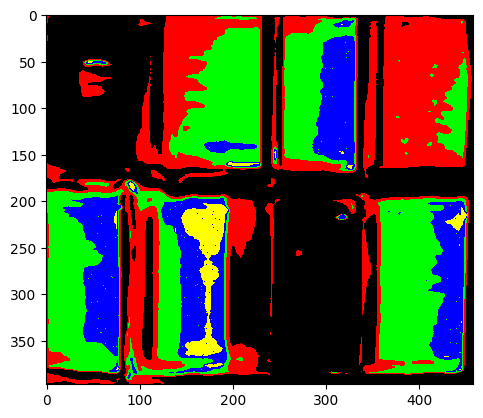

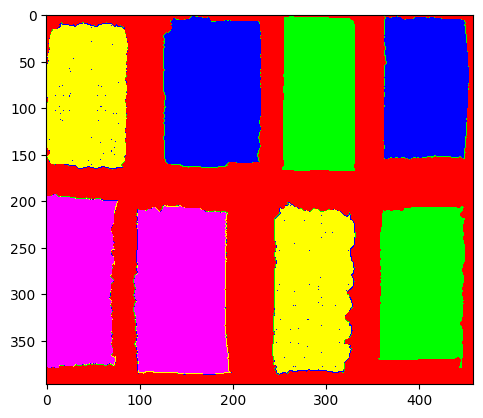

In [39]:
dir_cont = os.listdir(data_path)

print(dir_cont)

data_cubes = [cont for cont in dir_cont if '.nc' in cont]

num = 0;
classifier_created = False

for file in data_cubes:
    num += 1
    print("Processing file " + str(num) + ": " + file)
    
    # get files for this work
    fn = data_path + '/' + file
    png_fn = fn.split('.')[0] + ".png"
    gnd_t_fn = fn.split('.')[0] + ".csv"
    
    # read the netCDF file
    ds = nc.Dataset(fn)
    
    # extract the datacube from the dataset
    dc = np.array(ds['datacube'])
    
    # Data needs to be x, y, bands instead of bands, x, y.
    data_original = dc.transpose(1,2,0)
    
    # Read in ground truth
    ground_truth_original = np.array(np.loadtxt(gnd_t_fn, delimiter=','), dtype=np.int16)
    
    # Select ROI
    r = cv.selectROI("select roi", process_into_rgb(nc.Dataset(rad_path+'/'+file)))

    # close the window
    cv.destroyAllWindows()

    # Crop image
    ground_truth = ground_truth_original[int(r[1]):int(r[1]+r[3]),int(r[0]):int(r[0]+r[2])]

    # Crop hsi image
    data = data_original[int(r[1]):int(r[1]+r[3]),int(r[0]):int(r[0]+r[2]),:]
    
    # transform into pca acceptable format
    X = data.reshape(data.shape[0]*data.shape[1],data.shape[2])
    
    # use PCA to reduce the dimentionality of the data
    pca = PCA(n_components=nComp)
    pca.fit(X)
    pcX = pca.transform(X)
    
#     # Create and run K-Means
#     classifier = KMeans(n_clusters=nClusters)
    
#     # classify the hsi image
#     classified_data = classifier.fit(pcX)
    
#     # capture clusers and labels
#     x_labels = classifier.labels_
#     classified_image = x_labels.reshape(data[:, :, 0].shape)

    pcX_img = pcX.reshape((data[:,:,0].shape[0], data[:,:,0].shape[1], nComp))
    (classified_image, c) = kmeans(pcX_img, nClusters)
    
    # view the classified image
    v = imshow(classes=classified_image)
    classifications.append(classified_data)
    
    # view the ground truth
    v = imshow(classes=ground_truth)
    ground_truths.append(ground_truth)
    
    break

In [4]:
# If the classifications and ground_truths have been previously computed and saved, they can be read in here

run = True

in_path = "processed-data/secondary-capture/"

if run:        
    with open(in_path + 'k_means-classifications.pkl', 'rb') as out_file:
        classifications = pickle.load(out_file)

    with open(in_path + 'ground_truths.pkl', 'rb') as out_file:
        ground_truths = pickle.load(out_file)

In [5]:
y_pred = []
y_true = []

print("Evaluating Classifications...")

# Evaluate the classifications
for i in range(len(classifications)):
    print("Evaluating classification " + str(i) + "...")
      
    classified_data = classifications[i]
    ground_truth = ground_truths[i]
    
    # setup IoU data
    tp = empty.copy()
    fp = empty.copy()
    tn = empty.copy()
    fn = empty.copy()
    
    for i in classes:
        y_true.append(i)

        mask = ground_truth.copy()
        
        for x in range(classified_data.shape[0]-1):
            for y in range(classified_data.shape[1]-1):
                # create mask
                mask[x,y] = 1 if ground_truth[x,y] == i else 0
                
                # calculate classification metrics
                if ground_truth[x,y] == classified_data[x,y] == i: # true positive, both gt and classified classes match
                    tp[i-1] += 1
                elif ground_truth[x,y] == i and classified_data[x,y] != i: # false negative, gt and classified should match but classified doesn't
                    fn[i-1] += 1
                elif ground_truth[x,y] != i and classified_data[x,y] == i: # false positive, gt is not the class, but classified is
                    fp[i-1] += 1
                elif ground_truth[x,y] != i and classified_data[x,y] != i: # true negative the ground truth and the classified don't match
                    tn[i-1] += 1
                
        # Calculate IoU value for the class.
        iou = tp[i-1]/(tp[i-1]+fp[i-1]+fn[i-1])
        
        if iou > 0.5:
            # this is acceptable overlap
            y_pred.append(i)
        else:
            # this is not correct but for now, fill with most common class in masked region.
            cls_img = classified_data * mask

            line = cls_img.copy().reshape(cls_img.shape[0]*cls_img.shape[1])

            occurances = np.bincount(line)
            
            # i is the current class so remove it
            occurances = np.delete(occurances,i)
            
            # 0 will always be the most common because of the mask so delete it.
            occurances = np.delete(occurances,0)

            y_pred.append(np.argmax(occurances)+1)  

Evaluating Classifications...
Evaluating classification 0...
Evaluating classification 1...
Evaluating classification 2...
Evaluating classification 3...
Evaluating classification 4...
Evaluating classification 5...
Evaluating classification 6...
Evaluating classification 7...
Evaluating classification 8...
Evaluating classification 9...
Evaluating classification 10...
Evaluating classification 11...
Evaluating classification 12...
Evaluating classification 13...
Evaluating classification 14...
Evaluating classification 15...
Evaluating classification 16...
Evaluating classification 17...
Evaluating classification 18...
Evaluating classification 19...
Evaluating classification 20...
Evaluating classification 21...
Evaluating classification 22...
Evaluating classification 23...
Evaluating classification 24...
Evaluating classification 25...
Evaluating classification 26...
Evaluating classification 27...
Evaluating classification 28...
Evaluating classification 29...


### View results

note, due to the inaccurate ground truth, there are many errors in classification (technically) as the background is being *correctly* classified as what it should where it hasn't been labelled properly in the ground truth.

[useful](https://towardsdatascience.com/guide-to-confusion-matrices-classification-performance-metrics-a0ebfc08408e)

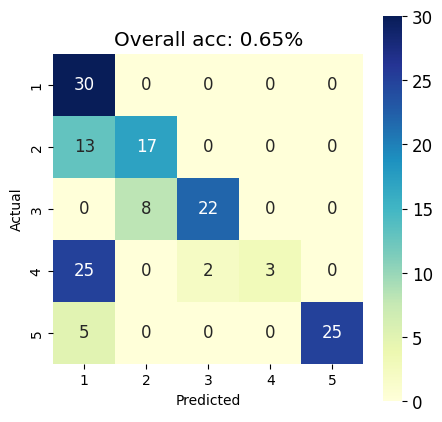

In [6]:
from sklearn.metrics import confusion_matrix, accuracy_score
import seaborn as sns
import pandas as pd

class_labels = ['background', 'beach sand', 'construction sand', 'soil', 'fish food']
class_labels = classes
 
# multilabel_confusion_matrix(y_true, y_pred, *, sample_weight=None, labels=None, samplewise=False)
cm = confusion_matrix(y_true, y_pred, labels=classes)

df_cm = pd.DataFrame(cm, columns=class_labels, index=class_labels)

fig, ax1 = plt.subplots(1,1, figsize=(5,5))
plt.rcParams['font.size'] = 12

sns.heatmap(df_cm, annot=True, ax=ax1,square=True,  cmap="YlGnBu",vmin=0,vmax=30,fmt='d')

ax1.set_title('Overall acc: {:.2f}%'.format(accuracy_score(y_true, y_pred)))
ax1.set_xlabel('Predicted')
ax1.set_ylabel('Actual');

In [46]:
# Save the classification and ground truth arrays for reuse.

out_path = "processed-data/secondary-capture/"

with open(out_path + 'k_means-classifications.pkl', 'wb') as out_file:
    pickle.dump(classifications, out_file)

with open(out_path + 'ground_truths.pkl', 'wb') as out_file:
    pickle.dump(ground_truths, out_file)